In [1]:
import json
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from tqdm import tqdm
import random
import numpy as np

Using TensorFlow backend.


In [2]:
%matplotlib inline

In [3]:
file = '/data/predict/1118CE339D057727/1118CE339D057727_logs.json'

In [4]:
#sessions = {}
#with open(file, encoding='utf8') as f:
#    for line in tqdm(f):
#        data = json.loads(line)
#        if data['session_id'] not in sessions:
#            sessions[data['session_id']] = []
#        for prod_idx in data['viewed_products']:
#            try:
#                sessions[data['session_id']].append(prod_idx)
#            except ValueError: 
#                print('Sktrain_labelsiped ' + prod_idx)

In [5]:
users = {}
with open(file, encoding='utf8') as f:
    for line in tqdm(f):
        data = json.loads(line)
        if data['visitor_id'] not in users:
            users[data['visitor_id']] = []
        for prod_idx in data['viewed_products']:
            try:
                users[data['visitor_id']].append(prod_idx)
            except ValueError: 
                print('Sktrain_labelsiped ' + prod_idx)

1664187it [00:08, 187019.04it/s]


In [6]:
#sessions_lens = list(map(lambda x: len(x), sessions.values()))
users_lens = list(map(lambda x: len(x), users.values()))

In [7]:
#print(len(sessions.keys()))
print(len(users.keys()))

432592


In [8]:
#d = plt.hist(sessions_lens, bins=100, range=(3, 103))

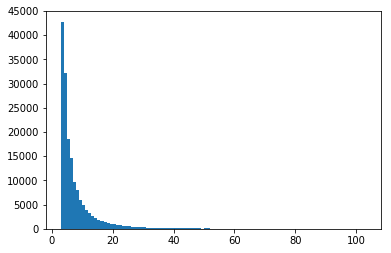

In [9]:
d = plt.hist(users_lens, bins=100, range=(3, 103))

In [10]:
products = {}
for u in users.values():
    for pid in u:
        products[pid] = 1
product_idxs = products.keys()
product_ids = {v: k for k, v in enumerate(product_idxs)}
number_of_classes = len(product_idxs)

In [11]:
def chunks(l, n):
    for i in range(0, len(l), n):
        yield l[i:i + n]

In [12]:
def dedup(seq):
    seen = set()
    seen_add = seen.add

    return [x for x in seq if not (x in seen or seen_add(x))]


users_with_product_idxs = {}
for uid,products in users.items():
    ids = dedup(list(map(lambda x: product_ids[x], products)))[-40:]
    if len(ids) > 1:
        if len(ids) not in users_with_product_idxs:
            users_with_product_idxs[len(ids)] = []
        users_with_product_idxs[len(ids)].append(ids)
    
#del users

In [13]:
max_batch_size = 32
test_size = 0.1
user_batches = []
user_valid_batches = []
for len_group in users_with_product_idxs.values():
    random.shuffle(len_group)
    for batch in chunks(len_group, max_batch_size):
        batch_data = np.array(list(map(lambda x: x[:-1], batch)))
        batch_labels = np.expand_dims(np.array(list(map(lambda x: x[1:], batch))), axis=2)
        if random.random() < test_size:
            user_valid_batches.append(
                (batch_data, batch_labels)
            )
        else:
            user_batches.append(
                (batch_data, batch_labels)
            )

In [14]:

def generate_from_array(arr):
    while True:
        random.shuffle(arr)
        for i in arr: 
            yield i
    

In [15]:
#raw_data = []
#raw_abels  = []
#for products in tqdm(users_with_product_idxs):
#    if(len(products) > 1):
#        for i in range(len(products) - 6):
#            raw_data.append(np.array(products[:-1]))
#            raw_abels.append(np.array(products[-1]))

In [16]:
#data_np = np.stack(raw_data)
#labels_np = np.expand_dims(np.stack(raw_abels), axis=1)

In [17]:
#from sklearn.model_selection import train_test_split
#train_data, valid_data, train_labels, valid_labels  = train_test_split(data_np , labels_np, test_size=0.10, shuffle=True)

In [76]:
from keras.models import Sequential
from keras.layers import Embedding, CuDNNGRU, Dense, Dropout, TimeDistributed,Bidirectional
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Nadam
from keras.optimizers import Nadam


n_hidden = 200

model=Sequential([
        Embedding(number_of_classes, n_hidden, batch_input_shape=(None,None)),
        BatchNormalization(),
        CuDNNGRU(4*n_hidden, input_shape=(None,n_hidden),return_sequences=True),
        Dropout(0.2),
        CuDNNGRU(4*n_hidden,return_sequences=True),
        Dropout(0.2),
#        TimeDistributed(Dense(n_hidden)),
        TimeDistributed(Dense(number_of_classes, activation='softmax'))
    ])

In [77]:
from keras.backend import reshape, prod, shape, stack
from keras.metrics import sparse_top_k_categorical_accuracy

def flatten_first_n_dimension(x, first_n=2):
    new_dims = stack([prod(shape(x)[:first_n]), prod(shape(x)[first_n:])])

    return reshape(x, new_dims)

def sparse_timedistributed_top_k_categorical_accuracy(y_true, y_pred, k=5):
    y_true_reshaped = flatten_first_n_dimension(y_true)
    y_pred_reshaped = flatten_first_n_dimension(y_pred)

    return sparse_top_k_categorical_accuracy(y_true_reshaped, y_pred_reshaped, k)

In [78]:
model.compile(loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy',sparse_timedistributed_top_k_categorical_accuracy], optimizer=Nadam())

In [79]:
model.fit_generator(
    generate_from_array(user_batches), 
    validation_data=generate_from_array(user_valid_batches), 
    steps_per_epoch=len(user_batches),
    validation_steps=len(user_valid_batches),
    epochs=4
)

Epoch 1/4
4377/4377 [==============================] - 464s 106ms/step - loss: 9.2164 - sparse_categorical_accuracy: 0.0379 - sparse_timedistributed_top_k_categorical_accuracy: 0.0803 - val_loss: 8.6285 - val_sparse_categorical_accuracy: 0.0502 - val_sparse_timedistributed_top_k_categorical_accuracy: 0.1155
Epoch 2/4
4377/4377 [==============================] - 468s 107ms/step - loss: 8.0491 - sparse_categorical_accuracy: 0.0599 - sparse_timedistributed_top_k_categorical_accuracy: 0.1393 - val_loss: 8.2282 - val_sparse_categorical_accuracy: 0.0654 - val_sparse_timedistributed_top_k_categorical_accuracy: 0.1527s
Epoch 3/4
4377/4377 [==============================] - 473s 108ms/step - loss: 7.1932 - sparse_categorical_accuracy: 0.0799 - sparse_timedistributed_top_k_categorical_accuracy: 0.1877 - val_loss: 8.0356 - val_sparse_categorical_accuracy: 0.0765 - val_sparse_timedistributed_top_k_categorical_accuracy: 0.1754
Epoch 4/4
4377/4377 [==============================] - 472s 108ms/step -

In [80]:
#model.fit(train_data, train_labels,validation_data=(valid_data,valid_labels), batch_size=256, epochs=4, shuffle=True)

In [81]:
model.save('/data/predict/1118CE339D057727/1118CE339D057727_predict_v1_dedup.h5')

In [82]:
model.save_weights('/data/predict/1118CE339D057727/1118CE339D057727_predict_weights_v1_dedup.h5')

In [83]:
model.load_weights('/data/predict/1118CE339D057727/1118CE339D057727_predict_weights_v1_dedup.h5')

In [84]:
#import csv
#with open('/data/predict/196E2517293A9285/196E2517293A9285_product_ids_1_dedup.csv', 'w') as csvfile:
#    spamwriter = csv.writer(csvfile)
#    for line in product_idxs:
#        spamwriter.writerow([line])

## Eye ball validation

In [85]:
import csv

In [86]:
product_map = {}
with open('/data/predict/1118CE339D057727/1118CE339D057727_catalog.csv', 'r', encoding='utf8') as csvfile:
    spamreader = csv.reader(csvfile)
    next(spamreader)
    for row in spamreader:
        product_map[row[0]] = [row[3], row[2], row[4]]

In [87]:
session = random.choice(random.choice(user_valid_batches)[0])
print(session)
# print(product_map)
product_map[list(product_idxs)[1]]
print(products)

[35759 27681 55406 43833 64457  4486 44662 69747 68760 37366]
['489630', '489630', '362040', '362039', '362037', '362039', '489627', '489627', '362039', '362037', '489630', '362037', '489627', '362040', '362040', '489627', '489627', '461651', '461651', '486327', '486327', '362037', '340335', '340335', '162044', '162044']


In [127]:
from IPython.core.display import display as core_display
from IPython.core.display import HTML 

def product_to_url(product):
    try:
        return [product] + product_map[list(product_idxs)[product]]
    except KeyError:
        return [product,'http://www.lackuna.com/wp-content/themes/fearless/images/missing-image-640x360.png','UNKNOWN','']

def display_session(session):
    products = list(map(product_to_url, session))
    predictions = model.predict([session])
    html = '<table>'
    seen = set()
    for i,product in enumerate(products):
        html += '<tr>'
        html += '<th style="text-align:center">'
        html += '<img src="' + product[1] + '" width="130"><br/>' 
        html += '<a href="'+str(product[3])+'">' + str(product[0]) + '</a></br>' + str(product[2])
        html += '</th><td style="background-color:black;"></td>'
        top_idx = list(np.argsort(predictions[i][0])[::-1])
        seen.add(product[0])
        
        j = 0
        for pred in top_idx:
            if pred in seen:
                continue
                                
            if i < len(products) - 1 and pred == products[i+1][0]:
                style = 'style="border:3px dashed red;"'
            else:
                style = ''
                
            pred_data = product_to_url(pred)
            html += '<td><img src="' + pred_data[1] + '" '+style+' width="130"><br/>' 
            html += '<a href="'+str(pred_data[3]) + '">' +str(pred_data[0]) + '</a></br>' + str(pred_data[2]) + '</td>'
            j+=1
            if j > 5:
                break
                
        html += '</tr>'
    html += '</table>'

    core_display(HTML(html))

display_session(random.choice(random.choice(user_valid_batches)[0]))

16515Canon EOS M3 fényképezőgép kit (18-55 S objektívvel + keresővel),,30763Nikon 50/F1.8 AF-S G objektív,"19067Olympus OM-D E-M5 Mark II kit (12-50 fekete objektívvel), ezüst","11859Apple Watch Series 1, 42mm, astroszürke színű alumíniumtok fekete sportszíjjal (mp032mp/a)","20352Canon PowerShot G9X Mark II fényképezőgép, ezüst","9135Nikon Coolpix P900 fényképezőgép, fekete",3859Canon EOS 800D fényképezőgép kit (18-200 objektívvel)
"20973Hans hidegvágó + kalapács készlet, 9 részes (040902-0001)",,"4733Electrolux EWFB1294BR elöltöltős mosógép, A+++","69260Delonghi ECOV311.BG Icona Vintage Presszó kávéfőző, bézs","35833Xbox One X 1TB játékkonzol, fekete",57925Global TK102B univerzális GPS nyomkövető,24041LG 43UD79-B 4K IPS LED monitor,"49715Gallet GALMS590 Smoothie turmixgép, fehér-zöld"
44088Bosch GOF 1250 CE Professional felsőmaró L-BOXX,,"35833Xbox One X 1TB játékkonzol, fekete","36060Xiaomi Redmi 4X 3GB/32GB Dual SIM kártyafüggetlen okostelefon, fekete (Android)",37222Skil 1001AT akkus fúró/csavarozó,2735Samsung UE43MU6102KXXH UHD SMART LED Televízió,"37156Samsung A520 Galaxy A5 (2017) kártyafüggetlen okostelefon, Black (Android)","38884 GoBoard Smart Balance Opticum Wheels 6,5 colos, fekete"
69493Extol mini köszörű és fúrógép (404120),,4887Mini köszörű- és csiszolófej tartozék készlet (73420),65915Extol Craft 404122 mini köszörű és fúrógép,24923Extol Craft 404130 mini köszörű és fúrógép,34896Extol Craft 404121 mini köszörű és fúrógép,"15370Mini köszörű-, vágó-, daraboló- és csiszolófej tartozék készlet (73415)","10101Mini köszörű-, csiszoló- és polírozófej tartozék készlet (73416)"
37500Hausmeister HM2001 hajszárító,,2367Renberg Edényszárító állvány RB-4323,"12510WD Black 3,5"" 4TB merevlemez - WD4003FZEX (Western Digital)","36872Soundmaster TR-85BE Retro táskarádió műbőr bevonattal, bézs",28682Lenspen Original NLP-2 tisztítóceruza gumírozott borítással + 1 cserefejjel,"1632Samsung Level Box mini Bluetooth-os hangszóró, ezüst","45378CellularLine Flap Essential eco-bőr tok iPhone 5/5S készülékhez, fehér"
19069Sencor SDC 100 Retró óra,,15237Sencor SDC 120 ébresztő óra,"3587Black & Decker KR705S32 ütvefúrógép, pótfogantyúval + Black & Decker A7216 32 részes tartozék szett + tároló táska","33121Xiaomi Redmi 4X 3GB/32GB Dual SIM kártyafüggetlen okostelefon, arany (Android)",60923Blaupunkt CRP8WH projektoros ébresztőórás rádió fehér színben,"36060Xiaomi Redmi 4X 3GB/32GB Dual SIM kártyafüggetlen okostelefon, fekete (Android)",20190Google Chromecast 2.0 HDMI Streaming Media Player Stick
"33475Xiaomi MiBand 2 aktivitásmérő karpánt pulzusmérővel, fekete",,"42784Alcor Move aktivitásmérő karpánt, fekete","31498Huawei A1 Band okoskarkötő, fekete","46966Honor Band 3 aktivitásmérő, Black",37835Xiaomi Mi Band 2 fitness karkötő szíj piros,"35833Xbox One X 1TB játékkonzol, fekete",53571Xiaomi Mi Band 2 fitness karkötő szíj rózsaszín
"19087MyKronoz ZeFit 3 okosóra, türkiz-fekete",,"44238MyKronoz ZeFit 3 Heartrate okosóra, arany-barna","31498Huawei A1 Band okoskarkötő, fekete","42784Alcor Move aktivitásmérő karpánt, fekete","69021Samsung Gear S3 Frontier okosóra, fekete","45834LG G Watch R okosóra, fekete","21730Technaxx TX-38 fitnesz karpánt, fekete"
52392Tiziano Zanini - A bonszaj,,"36060Xiaomi Redmi 4X 3GB/32GB Dual SIM kártyafüggetlen okostelefon, fekete (Android)","35833Xbox One X 1TB játékkonzol, fekete","33121Xiaomi Redmi 4X 3GB/32GB Dual SIM kártyafüggetlen okostelefon, arany (Android)","52750Lenovo Vibe S1 Lite kártyafüggetlen okostelefon, Blue (Android)","22298Nokia 3310 Dual SIM kártyafüggetlen mobiltelefon, Dark Blue","37156Samsung A520 Galaxy A5 (2017) kártyafüggetlen okostelefon, Black (Android)"
28832J. K. Rowling - Legendás állatok és megfigyelésük,,"56439Malmsten TG edző úszószemüveg, piros (MN-21111)","61502Remington CB7400 Hajsimító kefe (elektromos), kerámia bevonattal",14008 Hama szilikon fülhallgató pótgyűrű (3 méretben),4560LG AG-F310DP DUAL PLAY szemüveg,29705Philips DVT1200 4GB diktafon,"25882Gigapack álló bőr tok Hua